<a href="https://colab.research.google.com/github/aalonsca73/in_silico_toxicology/blob/main/PCA_PLS_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

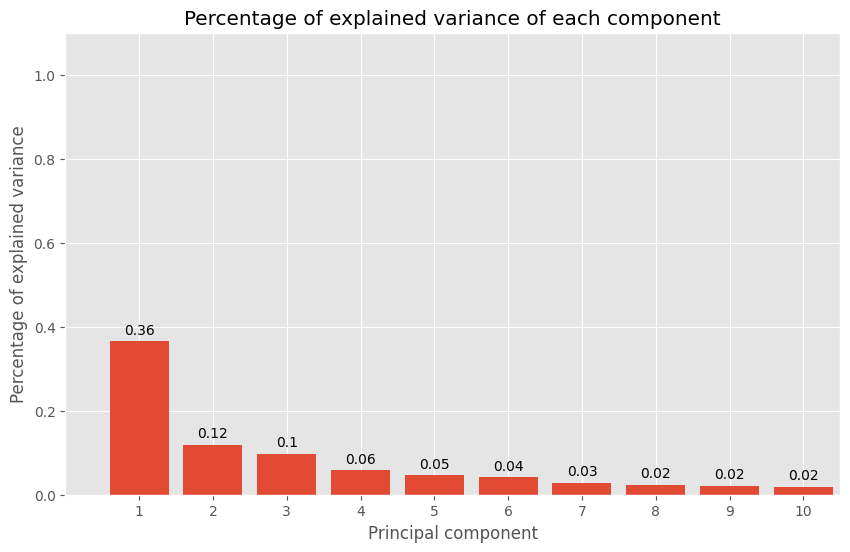

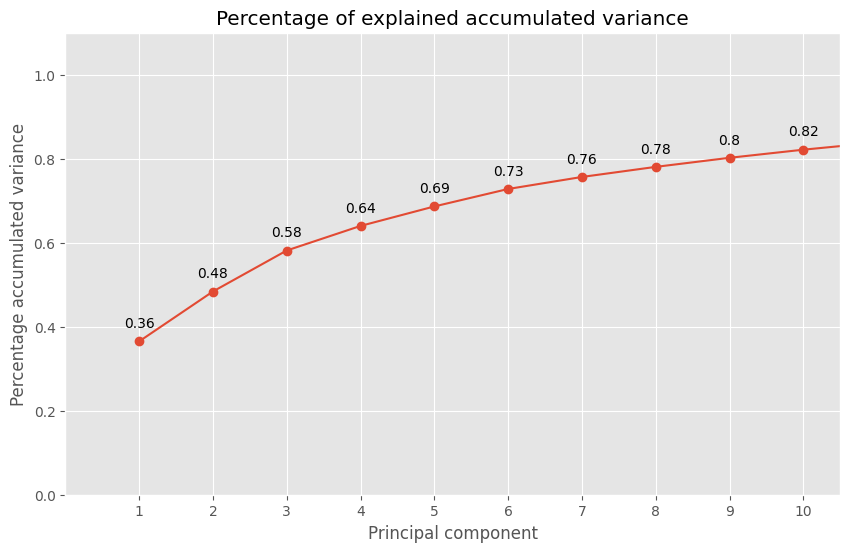

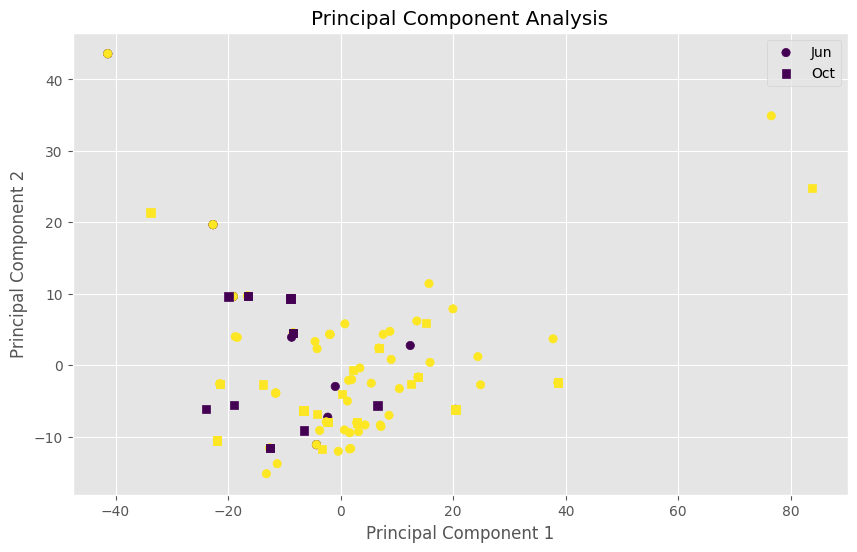

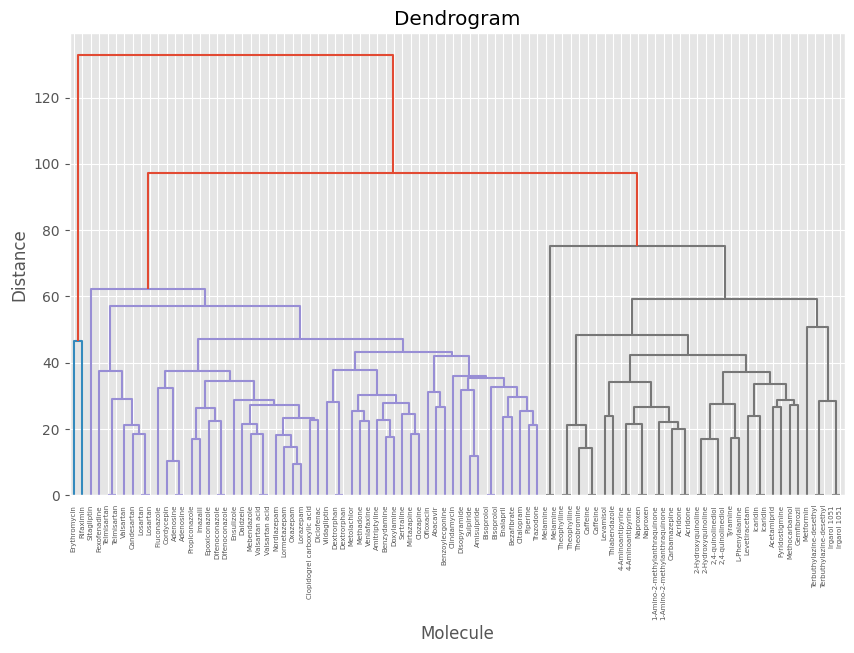

100% completed
Suggested number of components:  1



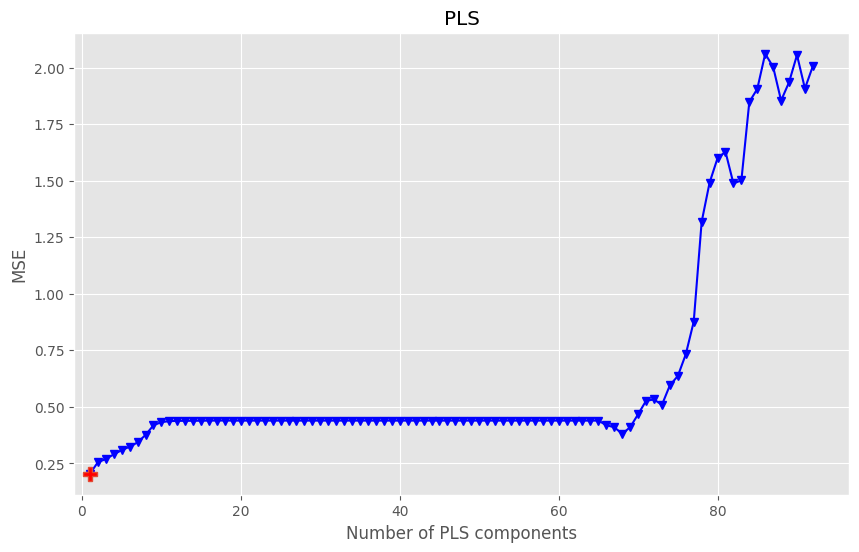

R2 calib: 0.336
R2 CV: -0.247
MSE calib: 0.109
MSE CV: 0.204
Accuracy score: 0.826
Confusion matrix
[[ 6 13]
 [ 3 70]]
AUC score: 0.64


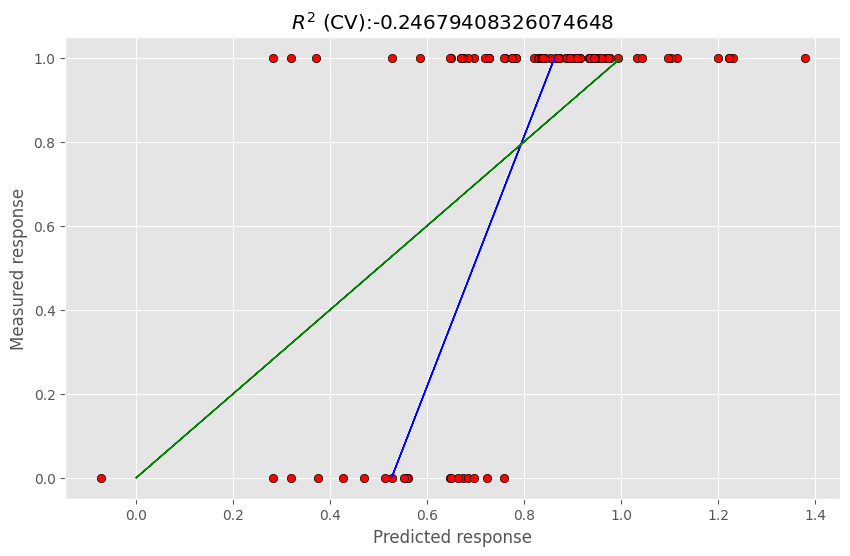

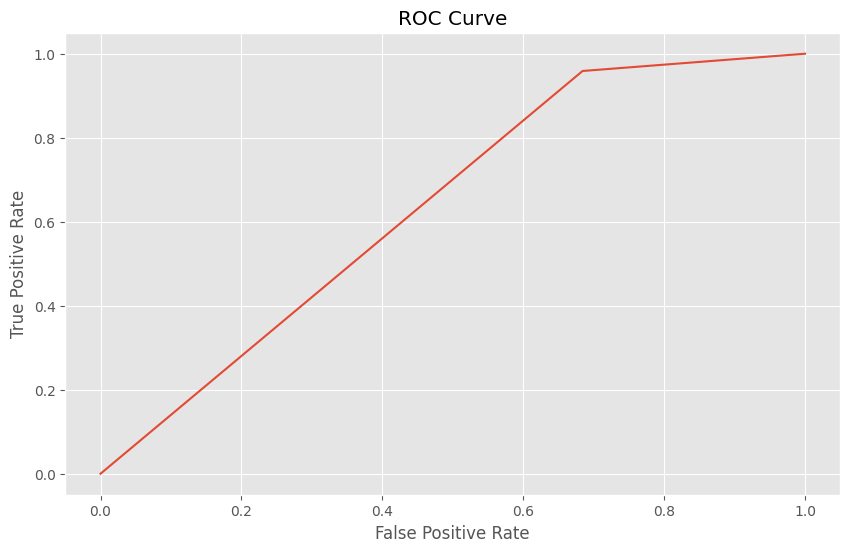

In [16]:
# Define the filename for the CSV file
filename = 'molecules_with_properties_CEC.csv'
labels_filename = 'llistes.xlsx'

# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.cluster.hierarchy import linkage, dendrogram
from sys import stdout

# Set the style for the plot
style.use('ggplot') # or plt.style.use('ggplot')

# Read the CSV file using pandas
df = pd.read_csv(filename)
labels_df = pd.read_excel(labels_filename,sheet_name=0,header=0)

# Remove the 'SMILES' column from the DataFrame
filtered_df = df.drop(columns="SMILES")
# Set the 'Name' column as the index
filtered_df = filtered_df.set_index('Name')

# Set the 'CEC' column as the index in labels_df
labels_df = labels_df.set_index('CEC')

# Find compounds that appear in both dataframes
common_compounds = filtered_df.index.intersection(labels_df.index)

# Filter to keep only the labels of common compounds
filtered_labels_df = labels_df.loc[common_compounds]

# Training PCA model with scaled data
pca_pipe = make_pipeline(StandardScaler(),PCA())
pca_pipe.fit(filtered_df)

# Extraction of the trained model from the pipeline
pca_model = pca_pipe.named_steps['pca']

# Transformation of the scaled data to obtain Principal Components
transformed_data = pca_pipe.transform(filtered_df)

# Convert array to dataframe
PCA = pd.DataFrame(data=transformed_data,index=filtered_df.index)

# Percentage of explained variance of each component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.bar(x=np.arange(pca_model.n_components_)+1,
       height = pca_model.explained_variance_ratio_)

# Add labels to the bars
for x,y in zip(np.arange(len(filtered_df.columns))+1, pca_model.explained_variance_ratio_):
    label = round(y,2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,5),ha='center')

ax.set_xticks(np.arange(pca_model.n_components_)+1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,1.1)
ax.set_title('Percentage of explained variance of each component')
ax.set_xlabel('Principal component')
ax.set_ylabel('Percentage of explained variance')

# Proportion of accumulated variance
prop_var_accum = pca_model.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
ax.plot(np.arange(len(pca_model.components_))+1,
        pca_model.explained_variance_ratio_.cumsum(), marker = 'o')

# Add labels to the data points
for x,y in zip(np.arange(len(filtered_df.columns))+1,pca_model.explained_variance_ratio_.cumsum()):
  label = round(y, 2)
  ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

ax.set_xticks(np.arange(pca_model.n_components_)+1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,1.1)
ax.set_title('Percentage of explained accumulated variance')
ax.set_xlabel('Principal component')
ax.set_ylabel('Percentage accumulated variance')

# Add 'Campaña' labels to the PCA DataFrame
PCA_labels = pd.merge(PCA,filtered_labels_df,on=PCA.index)

# PCA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Filter rows for 'Campaña'=='Jun'
jun_data = PCA_labels.query("Campaña == 'Jun'")
label_color_dict_jun = {label:idx for idx,label in enumerate(np.unique(jun_data['Cluster']))}
cvec_jun = [label_color_dict_jun[word] for word in jun_data['Cluster']]
ax.scatter(jun_data.loc[:, 0], jun_data.loc[:, 1], c=cvec_jun, marker='o', label='Jun')

# Filter rows for 'Campaña'=='Oct'
oct_data = PCA_labels.query("Campaña == 'Oct'")
label_color_dict_oct = {label:idx for idx,label in enumerate(np.unique(oct_data['Cluster']))}
cvec_oct = [label_color_dict_oct[word] for word in oct_data['Cluster']]
ax.scatter(oct_data.loc[:, 0], oct_data.loc[:, 1], c=cvec_oct, marker='s', label='Oct')

ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()  # Add legend to distinguish between 'Jun' and 'Oct'

# Clustering
complete_clustering = linkage(PCA,method="complete",metric="euclidean")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
dendrogram(complete_clustering,labels=filtered_df.index)

ax.set_title('Dendrogram')
ax.set_xlabel('Molecule')
ax.set_ylabel('Distance')

# Show the plots
plt.show()

# PLS regression
def optimise_pls_cv(X,y,n_comp,plot_components=True):
  """
  Optimize the number of components for Partial Least Squares (PLS) regression using cross-validation.

  Parameters:
  - X: Input features
  - y: Target variable
  - n_comp: Maximum number of components to test
  - plot_components: Whether to plot the optimization results

  Returns:
  None
  """

  # Run PLS including a variable number of components, up to n_comp, and calculate MSE
  mse = []
  component = np.arange(1,n_comp)

  for i in component:
    pls = PLSRegression(n_components=i)

    # Cross-validation
    y_cv = cross_val_predict(pls,X,y,cv=10)

    mse.append(mean_squared_error(y,y_cv))

    comp = 100*(i+1)/n_comp
    # Update status
    stdout.write("\r%d%% completed" % comp)
    stdout.flush()
  stdout.write("\n")

  # Calculate and print the position of minimum in MSE
  msemin = np.argmin(mse)
  print("Suggested number of components: ",msemin+1)
  stdout.write("\n")

  if plot_components is True:
    plt.figure(figsize=(10,6))
    plt.plot(component,np.array(mse), '-v', color = 'blue', mfc = 'blue')
    plt.plot(component[msemin],np.array(mse)[msemin], 'P', ms=10,mfc='red')
    plt.xlabel('Number of PLS components')
    plt.ylabel('MSE')
    plt.title('PLS')
    plt.xlim(left=-1)
    plt.show()

  # Define PLS object with optimal number of components
  pls_opt = PLSRegression(n_components=msemin+1)

  # Fit to the entire dataset
  pls_opt.fit(X,y)
  y_c = pls_opt.predict(X)

  # Cross-validation
  y_cv = cross_val_predict(pls_opt,X,y,cv=10)

  # Calculate scores for calibration and cross-validation
  score_c = r2_score(y,y_c)
  score_cv = r2_score(y, y_cv)

  # Calculate mean squared error for calibration and cross validation
  mse_c = mean_squared_error(y, y_c)
  mse_cv = mean_squared_error(y, y_cv)

  print('R2 calib: %5.3f'  % score_c)
  print('R2 CV: %5.3f'  % score_cv)
  print('MSE calib: %5.3f' % mse_c)
  print('MSE CV: %5.3f' % mse_cv)

  # Plot regression and figures of merit
  rangey = max(y) - min(y)
  rangex = max(y_c) - min(y_c)

  # Fit a line to the CV vs response
  z = np.polyfit(y, y_c, 1)
  fig,ax = plt.subplots(figsize=(10,6))
  ax.scatter(y_c, y, c='red',edgecolors='k')
  # Plot the best fit line
  ax.plot(np.polyval(z,y),y,c='blue',linewidth=1)
  # Plot the ideal 1:1 line
  ax.plot(y,y,color='green',linewidth=1)
  plt.title('$R^{2}$ (CV):'+str(score_cv))
  plt.xlabel('Predicted response')
  plt.ylabel('Measured response')

  y_pred = (y_c>0.5).astype('uint8')

  # Confusion matrix
  print(f'Accuracy score: {round(accuracy_score(y,y_pred),3)}')
  cf_mat = confusion_matrix(y,y_pred)
  print('Confusion matrix')
  print(cf_mat)

  # Plot ROC curve
  fig,ax=plt.subplots(figsize=(10,6))
  fpr,tpr,thresholds = roc_curve(y,y_pred)
  ax.plot(fpr,tpr)
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('ROC Curve')

  print(f'AUC score: {round(roc_auc_score(y,y_pred),2)}')

  plt.show()

  return


# Change labels to 0 and 1
filtered_labels_df['Cluster'].replace(to_replace=['Recalcitrants','Removed'],value=[0,1],inplace=True)
y = np.array(filtered_labels_df['Cluster'],dtype=int)

optimise_pls_cv(PCA,y,len(PCA.columns)+1,plot_components=True)

